To do list:

1) Large-N computation and understandings

- fit gaussian and exponential to the Madgraph data with large N (~10k?)
- remake the dynesty priors: pass from uniforms in the gaussians and exponentials parameters to (e.g.) biased gaussians around the true values.  Biased copmared to the fitted 'true' parameters, so that we'll check wheter the infering process can solve to the correct direction of the true parameters.
- Emin, Emax --> Eminb Emaxb, Eminh, Emaxh and corresponding modifications along dynesty notebook, now adapted to this new notebook
- run dynesty inference
- try to plot priors in the corner plots
- analyze outcome for fraction (whose prior shouold be constant)

2) Real-N limit (N ~ 300)

- redo everything

## Setup

In [1]:
import pandas as pd
import numpy as np
import ast
import math
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import stats
from scipy.stats import truncexpon
import pickle
import dynesty
from dynesty import utils as dyfunc
#from dynesty import plotting as dyplot
import plotting_customized as dyplot  # Self made variation of the original library to include the prior in dashed
import pickle
from dynesty import DynamicNestedSampler

#### Function definitions

In [3]:
# copmute invariant masses from a datraframe with the event

Eminbb = 100.0
Eminaa = 120.0
Emaxbb = 140.0
Emaxaa = 130.0
    
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


def expbb(x,a,l):
    return a * np.exp(-l*(x-Eminbb))
    
def expaa(x,a,l):
    return a * np.exp(-l*(x-Eminaa))
    

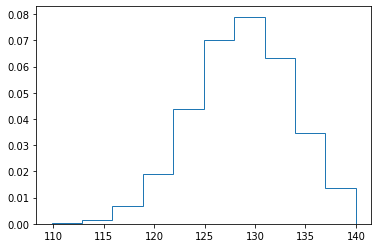

In [5]:
# signal h -> bb
mhbb = 129
shbb = 5
signal_bb = stats.truncnorm.rvs((Eminbb-mhbb)/shbb,(Emaxbb-mhbb)/shbb, loc=mhbb, scale=shbb, size=10000)
plt.hist(signal_bb, histtype='step', density=1)
plt.show()

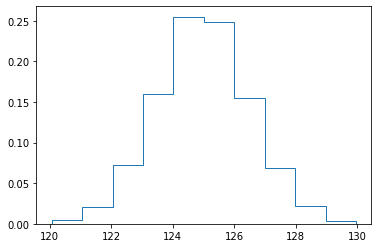

In [6]:
#signal h -> AA
mhaa = 125
shaa = 1.5
signal_aa = stats.truncnorm.rvs((Eminaa-mhaa)/shaa,(Emaxaa-mhaa)/shaa, loc=mhaa, scale=shaa, size=10000)
plt.hist(signal_aa, histtype='step', density=1)
plt.show()

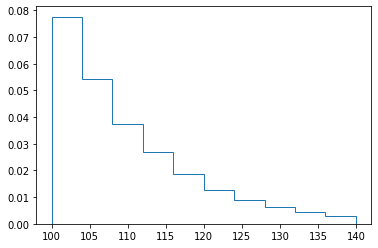

In [7]:
# background bb
expo_start = 100
expo_range = 40
lambda_bb = 0.09
b = expo_range * lambda_bb
background_bb = stats.truncexpon.rvs(b, loc=expo_start, scale=1/lambda_bb, size=100000)
plt.hist(background_bb, histtype='step', density=1)
plt.show()

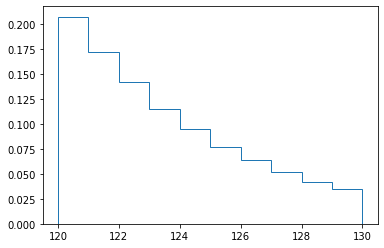

In [8]:
# background AA
expo_start = 120
expo_range = 10
lambda_aa = 0.2
b = expo_range * lambda_aa
background_aa = stats.truncexpon.rvs(b, loc=expo_start, scale=1/lambda_aa, size=100000)
plt.hist(background_aa, histtype='step', density=1)
plt.show()

In [9]:
# We now collect at will signal and background fake events with the above-set parameters
signal_events = [[signal_bb[i],signal_aa[i],1] for i in range(1000)]
background_events = [[background_bb[i], background_aa[i],0] for i in range(3000)]

## Create pseudo-data

determine luminosity and signal fraction

In [12]:
def create_data(N, pi_signal):
    Ns = int(N*pi_signal)
    Nb = int(N*(1-pi_signal))
    print(Ns,Nb)
    signal = random.sample(signal_events, Ns)
    signal = [x + [1] for x in signal]
    background = random.sample(background_events, Nb)
    background = [x + [0] for x in background]
    data = signal + background
    random.shuffle(data)    
    return data

150 350


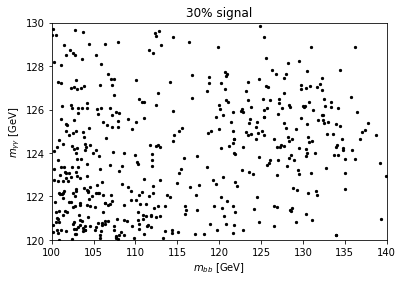

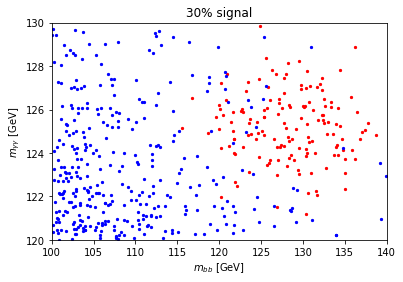

In [14]:
pi_s_true = 0.3
neff = 10000
lendata = 500
myrun = 'toy-model_dsampler_pi=' + str(pi_s_true) + '_neff=' + str(neff) +str(lendata)+'-events_strong-contrast'
X = create_data(lendata,pi_s_true)
plt.scatter([x[0] for x in X],[x[1] for x in X],c = 'black',s=5)
plt.xlim(Eminbb,Emaxbb)
plt.ylim(Eminaa,Emaxaa)
plt.xlabel('$m_{bb}$ [GeV]')
plt.ylabel('$m_{\gamma\gamma}$ [GeV]')
plt.title(str(int(pi_s_true*100))+'% signal')
plt.savefig(myrun+'_unlabeled.png')
plt.show()
plt.scatter([x[0] for x in X if x[2] == 1],[x[1] for x in X if x[2] == 1], s=5, c='red', label='signal')
plt.scatter([x[0] for x in X if x[2] == 0],[x[1] for x in X if x[2] == 0], s=5, c='blue', label='background')
plt.xlim(Eminbb,Emaxbb)
plt.ylim(Eminaa,Emaxaa)
plt.xlabel('$m_{bb}$ [GeV]')
plt.ylabel('$m_{\gamma\gamma}$ [GeV]')
plt.title(str(int(pi_s_true*100))+'% signal')
plt.savefig(myrun+'_labeled.png')
#plt.legend()
plt.show()

In [ ]:
# Attention: to use the same data as in the paper, import from the directory the files *.pkl

## Dynesty

#### Setup Dynesty

In [15]:
# t is the variables that contains the parameters of the likelihood, t = theta
# t = [muhbb, sigmahbb, muhaa, sigmahaa,  lb, lA, pi_S]
#
def psignaln(x,t,n):
    #return  stats.norm.pdf(x[n][0],t[0], t[1]) * stats.norm.pdf(x[n][1],t[0], t[1])
    return stats.truncnorm.pdf(x[n][0], (Eminbb-t[0])/t[1],(Emaxbb-t[0])/t[1], loc=t[0], scale=t[1]) * stats.truncnorm.pdf(x[n][1], (Eminaa-t[2])/t[3],(Emaxaa-t[2])/t[3], loc=t[2], scale=t[3])

def pbackgroundn(x,t,n):
    return ( t[4] * np.exp(- t[4] * (x[n][0] - Eminbb) ) / (1 - np.exp(- t[4] * (Emaxbb - Eminbb))) ) * ( t[5] * np.exp(- t[5] * (x[n][1] - Eminaa) ) / (1 - np.exp(- t[5] * (Emaxaa - Eminaa))) )
    
def pn(x,t,n):
    return ( 1 - t[6] ) * pbackgroundn(x,t,n) + ( t[6] ) * psignaln(x,t,n)

def lnp(x,t):
    return sum ( [ np.log(pn(x,t,n)) for n in range(len(x)) ] )

# This is a function of just t.  X should be a global variable (list) containing in each element
# the [mbb, maa] of event.
def loglike(t):
    return lnp(X,t)

In [16]:
popt_bb  = [0, mhbb, shbb]
popt_aa = [0, mhaa, shaa]
popt_bb_background = [0, lambda_bb]
popt_aa_background = [0, lambda_aa]
popt_bb, popt_aa, popt_bb_background, popt_aa_background

([0, 129, 5], [0, 125, 1.5], [0, 0.09], [0, 0.2])

In [18]:
# We bias the true parameters, paying attetntion to make sense the bias with the sigma, 
# and maintaining the sigma smaller that its corresponding allowed span range
popt_bb_biased = [0, mhbb*.95, shbb*1.30]
popt_aa_biased = [0, mhaa*0.99, shaa*0.90]
popt_bb_background_biased = [0, lambda_bb*1.4]
popt_aa_background_biased = [0, lambda_aa*0.75]
popt_bb_biased, popt_aa_biased, popt_bb_background_biased, popt_aa_background_biased

([0, 122.55, 6.5], [0, 123.75, 1.35], [0, 0.126], [0, 0.15000000000000002])

#### Prior: it should be biased from the true value

In [21]:
# Define the prior
alpha = 1
beta = 1
# Define our uniform prior.
def ptform(u):
    x = np.array(u)  # copy u
    x[0] = stats.norm.ppf(u[0], popt_bb_biased[1], popt_bb_biased[1]*0.06) # Mean for mbb center: A Normal with its center biased and a deviation equal to 5% of the mean
    x[1] = stats.norm.ppf(u[1], popt_bb_biased[2], popt_bb_biased[2]*0.15) # Sigma or mbb
    x[2] = stats.norm.ppf(u[2], popt_aa_biased[1], popt_aa_biased[1]*0.04) # Mean for mAA
    x[3] = stats.norm.ppf(u[3], popt_aa_biased[2], popt_aa_biased[2]*0.15) # Sigma for mAA   
    x[4] = stats.norm.ppf(u[4], popt_bb_background_biased[1], popt_bb_background_biased[1]*0.40) # lambda for bb
    x[5] = stats.norm.ppf(u[5], popt_aa_background_biased[1], popt_aa_background_biased[1]*0.40) # lambda for AA    
    x[6] = stats.beta.ppf(u[6], alpha, beta) # signal fraction
#    x[6] = 1 - u[6]
    return x
ndim = 7

### Sampling

In [55]:
%%time
dsampler = DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested(dlogz_init=0.01, nlive_init=2000, maxiter_init=9000, nlive_batch=150, n_effective=int(neff*2), maxbatch=250)

33108it [2:04:36,  4.43it/s, batch: 26 | bound: 41 | nc: 7 | ncall: 254194 | eff(%): 13.025 | loglstar: -2860.645 < -2838.322 < -2840.167 | logz: -2852.639 +/-  0.090 | stop:  0.982]  

CPU times: user 2h 4min 45s, sys: 1min 12s, total: 2h 5min 58s
Wall time: 2h 4min 36s


In [56]:
xtrue = [popt_bb[1], popt_bb[2], popt_aa[1], popt_aa[2], popt_bb_background[1], popt_aa_background[1], pi_s_true]
xtrue_biased = [popt_bb_biased[1], popt_bb_biased[2], popt_aa_biased[1], popt_aa_biased[2], popt_bb_background_biased[1], popt_aa_background_biased[1], pi_s_true]

In [58]:
results = dsampler.results

In [61]:
myresults = {'X': X, 'xtrue': xtrue, 'xtrue_biased': xtrue_biased}

In [64]:
with open(myrun+'_results.pkl', 'wb') as f:
    pickle.dump(results, f)
    
with open(myrun+'_my_results.pkl', 'wb') as f:
    pickle.dump(myresults, f)

In [66]:
means = [[myresults['xtrue_biased'][0],0.06*myresults['xtrue_biased'][0]], 
         [myresults['xtrue_biased'][1],0.15*myresults['xtrue_biased'][1]], 
         [myresults['xtrue_biased'][2],0.04*myresults['xtrue_biased'][2]], 
         [myresults['xtrue_biased'][3],0.15*myresults['xtrue_biased'][3]], 
         [myresults['xtrue_biased'][4],0.40*myresults['xtrue_biased'][4]], 
         [myresults['xtrue_biased'][5],0.40*myresults['xtrue_biased'][5]], 
         [0.5,0.5]]

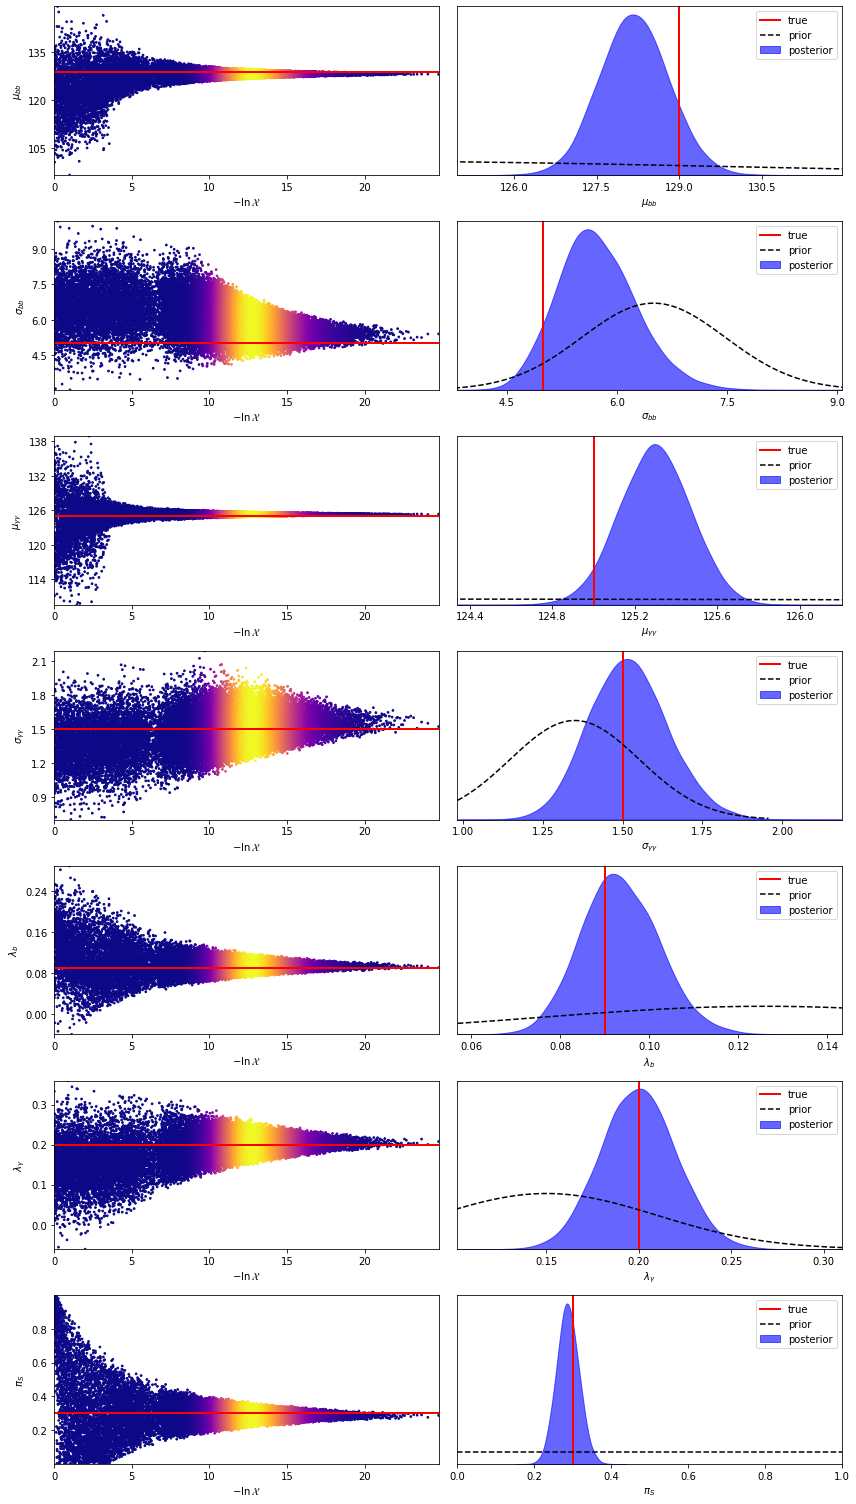

In [67]:
tfig2, taxes2 = dyplot.traceplot(results, post_color='blue', truths=myresults['xtrue'], means= means, quantiles=None, labels=['$\mu_{bb}$','$\sigma_{bb}$','$\mu_{\gamma\gamma}$','$\sigma_{\gamma\gamma}$','$\lambda_b$','$\lambda_\gamma$', '$\pi_S$'])

In [68]:
# Adjust limits for better visualization
taxes2[0][1].set_xlim(100,160)
taxes2[2][1].set_xlim(123-36,123+36)
taxes2[2][1].set_ylim(0,.1)
taxes2[4][1].set_xlim(means[4][0]-2*means[4][1],means[4][0]+2*means[4][1])
taxes2[4][1].set_ylim(0,20)
taxes2[5][1].set_xlim(means[5][0]-2*means[5][1],means[5][0]+2*means[5][1])
taxes2[6][1].set_xlim(0,1)

(0.0, 1.0)

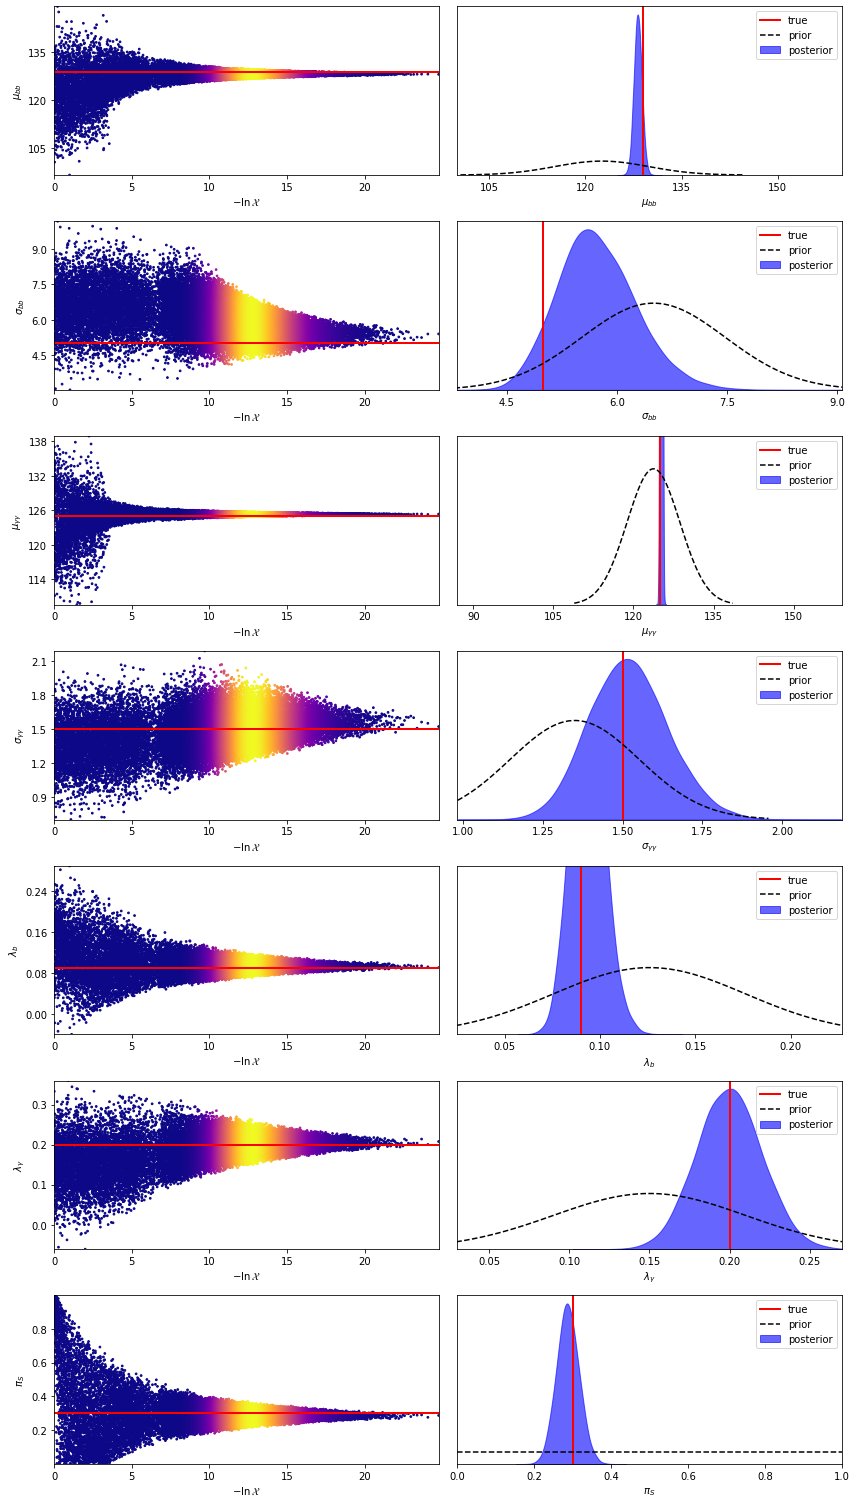

In [69]:
tfig2

In [38]:
tfig2.savefig('toy_model_500-events_larger_contrast.png')